<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/Model_Attempt2-akmostGood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 1. Imports ===
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving all_images.zip to all_images.zip


In [3]:
import zipfile
import os
import shutil

ZIP_FILE = "all_images.zip"
EXTRACT_DIR = "images"

# Remove existing directory if it exists
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)

# Create directory
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract zip
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Images extracted to:", EXTRACT_DIR)



Images extracted to: images


In [8]:
# === 2. Settings ===
IMAGE_DIR = "images"   # folder with your images
CSV_FILE = "final_dataset_paths.csv"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [11]:
# === 3. Load CSV and check columns ===
df = pd.read_csv(CSV_FILE)

# Ensure required columns exist
assert 'image_file' in df.columns, "CSV must have 'image_file' column"
assert 'labels' in df.columns, "CSV must have 'labels' column"

# Normalize filenames (strip any directories)
df['image_file'] = df['image_file'].apply(lambda x: x.split('/')[-1])

# Build full paths
df['full_path'] = df['image_file'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Filter out missing files
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"Images found: {len(df)}")

Images found: 1164


In [13]:
import re

# Remove extra quotes and whitespace, then split by comma
def clean_labels(s):
    # Remove square brackets
    s = s.strip("[]")
    # Remove extra quotes and spaces
    s = re.sub(r"[\"']", "", s)
    # Split by comma and strip whitespace
    return [lbl.strip() for lbl in s.split(",") if lbl.strip()]

df['class_list'] = df['labels'].apply(clean_labels)


In [15]:
# === IMPROVED LABEL CLEANING (ADD THIS NEW CELL) الي خطيتها===
def clean_labels_advanced(s):
    """
    IMPROVED VERSION: Better handling of messy labels
    """
    if pd.isna(s):
        return []

    # Remove square brackets and quotes
    s = str(s).strip("[]")
    s = re.sub(r"[\\\"'`]", "", s)  # More comprehensive quote removal

    # Split by comma and clean
    labels = [lbl.strip().lower() for lbl in s.split(",") if lbl.strip()]  # Added lowercase

    # Additional cleaning for problematic labels
    cleaned_labels = []
    for lbl in labels:
        # Remove any remaining special characters
        lbl = re.sub(r"[^a-zA-Z0-9\s]", "", lbl)
        lbl = lbl.strip()
        if lbl and len(lbl) > 1:  # Avoid single character labels
            cleaned_labels.append(lbl)

    return cleaned_labels

# Apply improved cleaning to a NEW column
df['class_list_improved'] = df['labels'].apply(clean_labels_advanced)

# Compare the results
print("=== COMPARISON ===")
print("BEFORE (current cleaning):")
print(df['class_list'].iloc[0])
print("\nAFTER (improved cleaning):")
print(df['class_list_improved'].iloc[0])

# Remove empty label lists
initial_count = len(df)
df = df[df['class_list_improved'].apply(len) > 0].reset_index(drop=True)
final_count = len(df)

print(f"\nImages before filtering: {initial_count}")
print(f"Images after filtering empty labels: {final_count}")
print(f"Removed {initial_count - final_count} images with no valid labels")

=== COMPARISON ===
BEFORE (current cleaning):
['Almond Coffee']

AFTER (improved cleaning):
['almond coffee']

Images before filtering: 1164
Images after filtering empty labels: 1164
Removed 0 images with no valid labels


In [16]:
# === 4. Multi-label encoding (multi-hot) ===
all_labels = sorted({lbl for sublist in df['class_list'] for lbl in sublist})
print("All labels:", all_labels)

# Create multi-hot columns
for lbl in all_labels:
    df[lbl] = df['class_list'].apply(lambda x: 1 if lbl in x else 0)

label_cols = all_labels
df['label_multihot'] = df[label_cols].values.tolist()


All labels: ['Afees', 'Almond Coffee', 'Areeqa', 'Basbousa', 'Bishamel', 'Bread', 'Cake', 'Chicken', 'Cream Caramel', 'Falafel', 'Fatteh', 'Fish', 'Foul', 'Grape Leaves', 'Henainee', 'Hummus', 'Jareesh', 'Jelly', 'Kibbeh', 'Kleija', 'Kunafa', 'Lahm Bi Ajeen', 'Luqaimat', 'Maamoul', 'Maqshoosh', 'Marqouq', 'Matazeez', 'Meat', 'Meat Soup', 'Mohalabiya', 'Molokhiya', 'Mousakhan', 'Moussaka', 'Muhammara', 'Musabeeb', 'Mutabbaq', 'Pasta', 'Pastry', 'Potato', 'Qishd', 'Qursan', 'Rice', 'Roz Bi Laban', 'Salad', 'Saleeg', 'Sambousa', 'Shakshuka', 'Soup', 'Umm Ali', 'Vegetable', 'Yogurt', '[Chicken']


In [17]:
# === 5. Train/Validation split ===
from sklearn.model_selection import train_test_split

# Use 'label_multihot' column which contains multi-hot vectors
X = df['full_path'].values
y = df['label_multihot'].values  # list of multi-hot vectors

# Split dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

NUM_CLASSES = len(df['label_multihot'][0])  # ensure this is correct

In [18]:
# === 6. Convert labels to numpy arrays ===
# This ensures all labels are float32 and proper shape
import numpy as np

train_labels = np.array([np.array(lbl, dtype=np.float32) for lbl in train_labels])
val_labels   = np.array([np.array(lbl, dtype=np.float32) for lbl in val_labels])

# === 6a. Preprocessing function ===
def preprocess_tf(path, label):
    # path is a string tensor
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

# === 6b. Build tf.data.Dataset objects ===
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(500)\
                   .batch(BATCH_SIZE)\
                   .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)\
               .batch(BATCH_SIZE)\
               .prefetch(tf.data.AUTOTUNE)

In [19]:
# === 7. Build EfficientNetB0 multi-label model ===
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

def build_efficientnet_multilabel(num_classes):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False  # freeze base

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)  # sigmoid for multi-label

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

efficientnet_model = build_efficientnet_multilabel(NUM_CLASSES)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# === 8. Build MobileNetV2 multi-label model ===
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2_multilabel(num_classes):
    base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

mobilenet_model = build_mobilenetv2_multilabel(NUM_CLASSES)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# === 9. Train EfficientNetB0 ===
EPOCHS = 10

history_efficientnet = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - auc: 0.6057 - binary_accuracy: 0.8816 - loss: 0.3006 - precision: 0.0484 - recall: 0.1338 - val_auc: 0.7684 - val_binary_accuracy: 0.9715 - val_loss: 0.1104 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - auc: 0.7425 - binary_accuracy: 0.9697 - loss: 0.1183 - precision: 0.2743 - recall: 0.0455 - val_auc: 0.7630 - val_binary_accuracy: 0.9715 - val_loss: 0.1114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - auc: 0.7331 - binary_accuracy: 0.9701 - loss: 0.1187 - precision: 0.2925 - recall: 0.0452 - val_auc: 0.7642 - val_binary_accuracy: 0.9715 - val_loss: 0.1110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - auc: 0.7510 - binary_accuracy: 0.9700 - loss: 0.1144 - precision: 0.2168 - recall: 0.0275 - val_auc: 0.7699 - val_binary_accuracy: 0.9715 - val_loss: 0.1092 - val

In [22]:
# === 10. Train MobileNetV2 ===
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 718ms/step - auc: 0.6592 - binary_accuracy: 0.8953 - loss: 0.2562 - precision: 0.0924 - recall: 0.1794 - val_auc: 0.9141 - val_binary_accuracy: 0.9775 - val_loss: 0.0770 - val_precision: 0.9091 - val_recall: 0.2319
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 725ms/step - auc: 0.9076 - binary_accuracy: 0.9773 - loss: 0.0779 - precision: 0.7038 - recall: 0.3244 - val_auc: 0.9680 - val_binary_accuracy: 0.9812 - val_loss: 0.0554 - val_precision: 0.8824 - val_recall: 0.3913
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 707ms/step - auc: 0.9751 - binary_accuracy: 0.9838 - loss: 0.0502 - precision: 0.8640 - recall: 0.4986 - val_auc: 0.9840 - val_binary_accuracy: 0.9852 - val_loss: 0.0422 - val_precision: 0.8952 - val_recall: 0.5449
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 667ms/step - auc: 0.9906 - binary_accuracy: 0.9879 - loss: 0.0360 - precision: 0.8945 - recall: 0.6594 - val_auc: 0.9897 - val_binary_accuracy: 0.9874 - val_loss: 0.0354 - val_precision: 

In [24]:
# === PREDICTION AND EVALUATION ===

# Save the best performing model (MobileNetV2 based on training metrics)
mobilenet_model.save('best_multilabel_model.h5')

# Load best model
best_model = tf.keras.models.load_model('best_multilabel_model.h5')

# Make predictions
val_predictions = best_model.predict(val_ds)

# Convert to binary predictions
val_pred_binary = (val_predictions > 0.5).astype(int)

# Evaluate
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(val_labels, val_pred_binary,
                          target_names=all_labels,
                          zero_division=0))

# Prediction function for new images
def predict_multilabel(image_path, model, threshold=0.5):
    """Predict multiple labels for a single image"""
    # Preprocess
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    # Predict
    predictions = model.predict(img)[0]

    # Get labels above threshold
    predicted_labels = []
    for i, prob in enumerate(predictions):
        if prob > threshold:
            predicted_labels.append((all_labels[i], float(prob)))

    # Sort by confidence
    predicted_labels.sort(key=lambda x: x[1], reverse=True)

    return predicted_labels

# Test on a sample
sample_idx = 0
sample_image = df.iloc[sample_idx]['full_path']
actual_labels = df.iloc[sample_idx]['class_list_improved'] # Corrected column name
predictions = predict_multilabel(sample_image, best_model)

print(f"\nSample Prediction Test:")
print(f"Image: {sample_image.split('/')[-1]}")
print(f"Actual: {actual_labels}")
print(f"Predicted: {[lbl for lbl, conf in predictions]}")
print(f"Confidences: {[f'{conf:.3f}' for lbl, conf in predictions]}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 976ms/step
Classification Report:
               precision    recall  f1-score   support

        Afees       1.00      1.00      1.00         1
Almond Coffee       1.00      0.33      0.50         3
       Areeqa       1.00      1.00      1.00         2
     Basbousa       1.00      1.00      1.00         3
     Bishamel       1.00      0.50      0.67         2
        Bread       1.00      0.89      0.94         9
         Cake       1.00      0.86      0.92         7
      Chicken       0.83      0.95      0.89        37
Cream Caramel       1.00      0.80      0.89         5
      Falafel       1.00      1.00      1.00         1
       Fatteh       0.00      0.00      0.00         3
         Fish       1.00      0.67      0.80         3
         Foul       0.00      0.00      0.00         0
 Grape Leaves       1.00      0.50      0.67         2
     Henainee       1.00      1.00      1.00         2
       Hummus       1.00      0.60      0.75         5

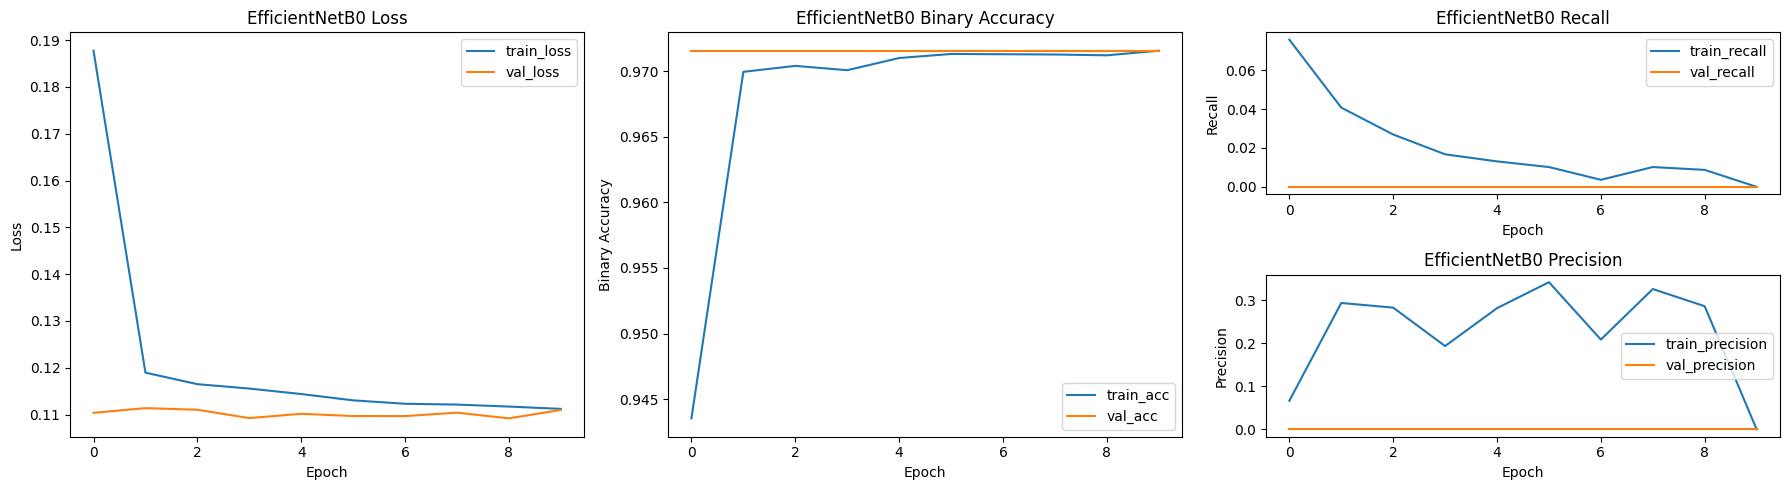

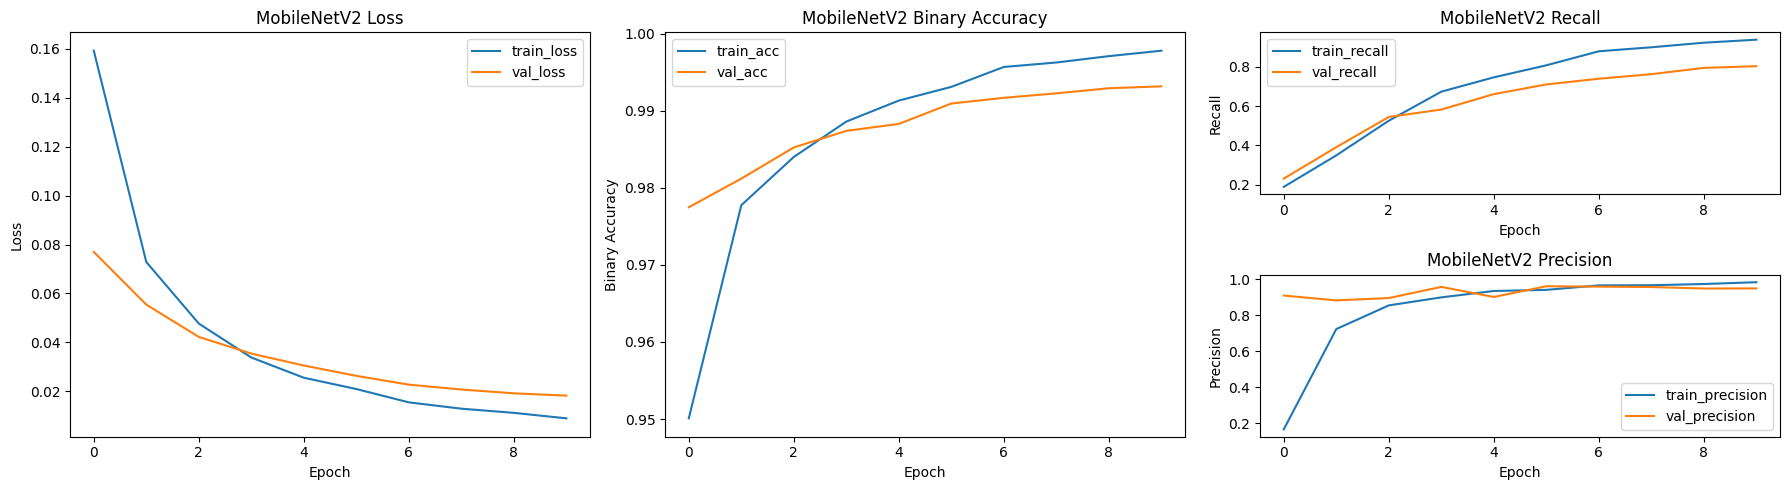

In [25]:
# === 11. Plot training history with separate Precision & Recall ===
import matplotlib.pyplot as plt

def plot_history_separate(history, title="Model Performance"):
    plt.figure(figsize=(18,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Binary Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['binary_accuracy'], label='train_acc')
    plt.plot(history.history['val_binary_accuracy'], label='val_acc')
    plt.title(f'{title} Binary Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,3,6)  # Place precision in lower row
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title(f'{title} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,3,3)  # Place recall in upper row
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.title(f'{title} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_history_separate(history_efficientnet, "EfficientNetB0")
plot_history_separate(history_mobilenet, "MobileNetV2")


In [26]:
# === Visualize sample predictions ===
import pandas as pd
import numpy as np
import tensorflow as tf

def show_sample_predictions(model, val_paths, val_labels, label_cols, sample_size=10):

    idxs = np.random.choice(len(val_paths), size=sample_size, replace=False)
    paths_sample = [val_paths[i] for i in idxs]
    labels_sample = val_labels[idxs]

    # Load and preprocess images
    images = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(p, target_size=(224,224))) / 255.0 for p in paths_sample]
    images = np.array(images)

    # Get predictions
    preds = model.predict(images)
    preds_labels = [[label_cols[j] for j, p in enumerate(pred) if p >= 0.5] for pred in preds]
    actual_labels = [[label_cols[j] for j, l in enumerate(label_row) if l==1] for label_row in labels_sample]

    # Create DataFrame
    df_sample = pd.DataFrame({
        "image_file": paths_sample,
        "predicted_labels": preds_labels,
        "actual_labels": actual_labels
    })
    display(df_sample)

# Example usage:
print("EfficientNetB0 Sample Predictions:")
show_sample_predictions(efficientnet_model, val_paths, val_labels, label_cols, sample_size=20)

print("\nMobileNetV2 Sample Predictions:")
show_sample_predictions(mobilenet_model, val_paths, val_labels, label_cols, sample_size=20)


EfficientNetB0 Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


,image_file,predicted_labels,actual_labels
0,images/img(207)-R0.jpg,[],[Bread]
1,images/img(151)-H.jpg,[],[Yogurt]
2,images/img(307).jpg,[],[Umm Ali]
3,images/img(248)-V.jpg,[],[Sambousa]
4,images/img(7)-H.jpg,[],[Rice]
5,images/img(310)-H.jpg,[],"[Bishamel, Pasta]"
6,images/img(12)-R-4.jpg,[],[Areeqa]
7,images/img(38)-H.jpg,[],"[Meat, Rice]"
8,images/img(240)-V.jpg,[],"[Meat, Vegetable, Yogurt]"
9,images/img(174)-R-24.jpg,[],"[Chicken, Rice]"



MobileNetV2 Sample Predictions:


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


,image_file,predicted_labels,actual_labels
0,images/img(103)-R22.jpg,"[Meat, Rice]","[Meat, Rice, Vegetable]"
1,images/img(146)-H.jpg,[Meat Soup],[Meat Soup]
2,images/img(295)-V.jpg,[Chicken],[Mutabbaq]
3,images/img(240)-H.jpg,[],"[Meat, Vegetable, Yogurt]"
4,images/img(196)-H.jpg,[Salad],[Salad]
5,images/img(141)-R-9.jpg,[Salad],[Salad]
6,images/img(26).jpg,[Bread],[Bread]
7,images/img(271)-H.jpg,[Lahm Bi Ajeen],[Lahm Bi Ajeen]
8,images/img(17)-H.jpg,[Sambousa],[Sambousa]
9,images/img(175).jpg,[Rice],"[Rice, Vegetable]"
